# Inicialização

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

In [94]:
ROOT = os.path.abspath('..')
DATA = os.path.join(ROOT, 'data', 'external')
df = pd.read_csv(os.path.join(DATA, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA, 'test.csv'))
df_target = pd.read_csv(os.path.join(DATA, 'sample_submission.csv'))

In [95]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


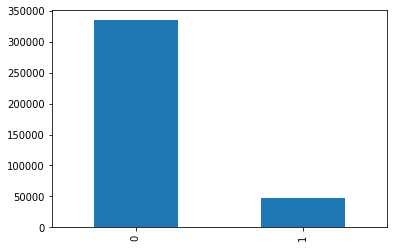

In [96]:
df['Response'].value_counts().plot.bar()

# Pré-Processamento

In [97]:
from sklearn.preprocessing import OrdinalEncoder

Dados de treinamento

In [98]:
df.select_dtypes(include=['object'])

,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No
...,...,...,...
381104,Male,1-2 Year,No
381105,Male,< 1 Year,No
381106,Male,< 1 Year,No
381107,Female,> 2 Years,Yes


In [99]:
encoder = OrdinalEncoder(dtype=np.int)

In [100]:
df[['Gender', 'Vehicle_Age', 'Vehicle_Damage']] = encoder.fit_transform(df.select_dtypes(include=['object']))

In [101]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

- Gender
    - Male = 1
    - Female = 0
- Vehicle_Age
    - 1-2 Year = 0
    - < 1 Year = 1
    - \> 2 Years = 2
- Vehicle_Damage
    - No = 0
    - Yes = 1

In [102]:
df.dtypes

id                        int64
Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [103]:
df['Region_Code'] = df['Region_Code'].astype(dtype=np.int)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(dtype=np.int)

Realizando o SMOTENN

In [104]:
# from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

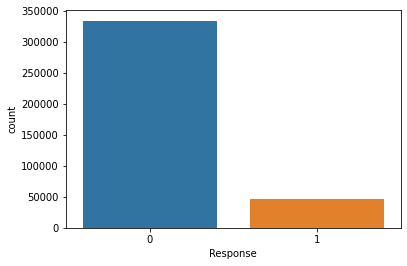

In [105]:
sns.countplot(df['Response']);

In [106]:
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28,0,2,1,40454.0,26,217,1
1,2,1,76,1,3,0,0,0,33536.0,26,183,0
2,3,1,47,1,28,0,2,1,38294.0,26,27,1
3,4,1,21,1,11,1,1,0,28619.0,152,203,0
4,5,0,29,1,41,1,1,0,27496.0,152,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26,1,0,0,30170.0,26,88,0
381105,381106,1,30,1,37,1,1,0,40016.0,152,131,0
381106,381107,1,21,1,30,1,1,0,35118.0,160,161,0
381107,381108,0,68,1,14,0,2,1,44617.0,124,74,0


In [107]:
oversample = SMOTE(random_state=42)
X = df.drop(labels=['id', 'Response'], axis=1)
y = df['Response']
X_res, y_res = oversample.fit_resample(X, y)

In [109]:
df = X_res
df['Response'] = y_res

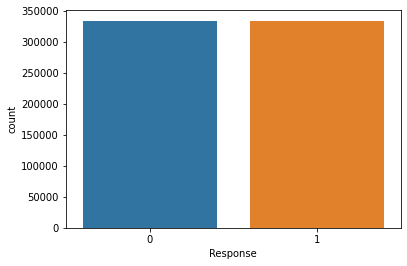

In [110]:
sns.countplot(df['Response']);

In [111]:
DATA_CSV = os.path.join(ROOT, 'data', 'processed')
df.to_csv(os.path.join(DATA_CSV, 'train.csv'), index= False)

Dados de teste

In [112]:
df_test.select_dtypes(include=['object'])

,Gender,Vehicle_Age,Vehicle_Damage
0,Male,< 1 Year,No
1,Male,1-2 Year,Yes
2,Male,1-2 Year,Yes
3,Male,< 1 Year,Yes
4,Male,< 1 Year,No
...,...,...,...
127032,Female,< 1 Year,No
127033,Female,1-2 Year,Yes
127034,Male,< 1 Year,No
127035,Male,1-2 Year,No


In [113]:
df_test[['Gender', 'Vehicle_Age', 'Vehicle_Damage']] = encoder.transform(df_test.select_dtypes(include=['object']))

In [114]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

- Gender
    - Male = 1
    - Female = 0
- Vehicle_Age
    - 1-2 Year = 0
    - < 1 Year = 1
    - \> 2 Years = 2
- Vehicle_Damage
    - No = 0
    - Yes = 1

In [115]:
df_test['Region_Code'] = df_test['Region_Code'].astype(dtype=np.int)
df_test['Policy_Sales_Channel'] = df_test['Policy_Sales_Channel'].astype(dtype=np.int)

In [116]:
df_test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,1,25,1,11,1,1,0,35786.0,152,53
1,381111,1,40,1,28,0,0,1,33762.0,7,111
2,381112,1,47,1,28,0,0,1,40050.0,124,199
3,381113,1,24,1,27,1,1,1,37356.0,152,187
4,381114,1,27,1,28,1,1,0,59097.0,152,297
...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,0,26,1,37,1,1,0,30867.0,152,56
127033,508143,0,38,1,28,0,0,1,28700.0,122,165
127034,508144,1,21,1,46,1,1,0,29802.0,152,74
127035,508145,1,71,1,28,1,0,0,62875.0,26,265


In [117]:
df_test = df_test.merge(df_target, how='inner', on='id')

In [118]:
df_test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,381110,1,25,1,11,1,1,0,35786.0,152,53,0
1,381111,1,40,1,28,0,0,1,33762.0,7,111,0
2,381112,1,47,1,28,0,0,1,40050.0,124,199,0
3,381113,1,24,1,27,1,1,1,37356.0,152,187,0
4,381114,1,27,1,28,1,1,0,59097.0,152,297,0
...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,0,26,1,37,1,1,0,30867.0,152,56,0
127033,508143,0,38,1,28,0,0,1,28700.0,122,165,0
127034,508144,1,21,1,46,1,1,0,29802.0,152,74,0
127035,508145,1,71,1,28,1,0,0,62875.0,26,265,0


In [119]:
DATA_CSV = os.path.join(ROOT, 'data', 'processed')
df_test.to_csv(os.path.join(DATA_CSV, 'test.csv'), index= False)